In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt 
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

In [54]:
class Processing:
    def __init__(self, filedataset, begining_training, end_training,end_testing, timestamp, features, target):
        self.timestamp = timestamp
        self.features  = features
        self.begining_training = begining_training
        self.end_training = end_training
        self.end_testing = end_testing
        self.df  = self.importDataset()
        self.x_train = []
        self.y_train = []
        self.x_test  = []
        self.y_test  = []
        self.scaler_x = None
        self.scaler_y = None
        self.target = target
        self.df_training =  None
        self.df_test = None
        self.splitData()
    
    
    def diffdataset(self, dataset):
        dataset = np.log( dataset).diff().dropna()
        return dataset 

    def importDataset(self):
        parser = lambda x: pd.datetime.strptime(x, "%Y.%m.%d %H:%M:%S")
        df = pd.read_csv( 'arquivos_de_coleta/'+filedataset, sep=';', header=0, parse_dates=['time'],date_parser=parser) 
        return df
    
    def selectInterval(self, start, end):
        mask = (self.df['time'] > start) & (self.df['time'] <= end )
        return self.df.loc[mask]
    
    def scalerDataset(self, dataset):
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.scaler_x.fit(dataset)
        self.scaler_y.fit(self.df_training[[target]])
        return self.scaler_x.transform(dataset)

    def processXY(self, dataframe):
        length = len(dataframe)
        x_data = []
        y_data = []
        maximum = 0
        minimum = 0
        for i in range(self.timestamp, length):
            x_data.append( dataframe.iloc[i-self.timestamp:i,:].values)
            #y_data.append( dataframe.iloc[i,self.features.index(target)])
            maximum = dataframe[['max1','max2','max3','max4']].max(axis=1).loc[i]
            minimum = dataframe[['min1','min2','min3','min4']].min(axis=1).loc[i]
            point_mean = (maximum-minimum)/2
            y_data.append( point_mean )
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        x_data = np.reshape(x_data, (x_data.shape[0], self.timestamp, len(features)))
        return x_data, y_data
     
    def splitData(self):
        #Selecionando Intervalos de datas para treino
        self.df_training = self.selectInterval(self.begining_training, self.end_training)
        #selecionando colunas para treino
        self.df_training = self.df_training[self.features]
        #Escalando o dataset de treino usando a funcao MinMax()
        #self.x_train = self.scalerDataset(self.df_training)
        #Processando o dataset com o shape adequado para a modelagem x
        self.x_train = self.diffdataset(self.df_training)
        self.x_train, self.y_train = self.processXY( self.x_train )
        #Selecionando Intervalos de datas para teste
        self.df_test = self.selectInterval(self.end_training, self.end_testing)
        #selecionando colunas do dataset para teste
        self.x_test = self.df_test[self.features]
        #Escalando o dataset de treino
        self.x_test = self.diffdataset(self.x_test)
        #self.x_test = self.scaler_x.transform(self.x_test)
        #Processando o dataset com o shape adequado para a modelagem 
        self.x_test , self.y_test  = self.processXY( self.x_test )


#########################Fim da classe de processamento############################################################

class Training:
    def __init__(self, ds, neurons, timestamp, features, epochs):
        self.model = None
        self.ds = ds
        self.neurons = neurons
        self.timestamp = timestamp
        self.features = features
        self.epochs = epochs
        self.trainingLSTM()
        
    def configuringLSTM(self):
        self.model = Sequential()
        self.model.add(LSTM(units = self.neurons, return_sequences = False, input_shape=( self.timestamp , len(self.features) ) ))
        # self.model.add(Dropout(0.01))
        self.model.add(Dense(1))
        self.model.compile(loss='mae', optimizer='adam')
    
    def trainingLSTM(self):
        self.configuringLSTM()
        self.model.fit(self.ds.x_train, self.ds.y_train, epochs = self.epochs)
        self.model.save('LSTM_GBPUSD')

#########################Fim da classe de Treinamento#############################################################

class Testing:
    def __init__(self, modelTraining, ds ):
        self.modelTraining  = modelTraining
        self.ds     = ds
        self.y_test = []
        self.predictedPrice = []
        self.prevision = None
        self.time = None
        self.max = None
        self.min = None
        self.open = None
        self.result_to_csv = None
        self.predicting()
        self.estatistical()
    
    # def inverse_diff(self, dataset):
    #     print(self.ds.df_training)
    #     #print(self.ds.df_test)
    #     #print(self.ds.x_test)
    #     value_primary = self.ds.df_training.values[-1]
    #     print(value_primary)
    #     value_primary = value_primary.reshape(1,4)
    #     print(self.ds.x_test.shape)
    #     dool =  np.cumprod( np.r_[ value_primary , np.exp( self.ds.x_test ) ], axis=0 )
    #     print( dool )

    def predicting(self):
        self.predictedPrice =  self.modelTraining.model.predict(self.ds.x_test) 
    
    def estatistical(self):
        values_primary = self.ds.df_test['close4'].shift(-self.ds.timestamp+1).values
        # print(np.cumprod( np.r_[ values_primary[0] , np.exp( self.predictedPrice[0] ) ], axis=0 ))
        ds_tested = self.ds.df_test[['max1','max2','max3','max4']].max(axis=1).loc[0]
        print(ds_tested)
        # predicted_transform = []
        # for i in range(len( self.predictedPrice ) ):
        #     predicted_transform.append( np.cumprod( np.r_[ values_primary[i] , np.exp( self.predictedPrice[i]) ])[1] )
        # self.y_test         = pd.DataFrame(data=self.ds.df_test['close4'].shift(-self.ds.timestamp).dropna().values, columns=['Y_TEST'])
        # self.prevision      = pd.DataFrame(data=predicted_transform, columns=['Previsão'])
        # self.time           = pd.DataFrame(data=self.ds.df_test['time'].shift(-self.ds.timestamp).dropna().values, columns=['Data'])
        # self.open           = pd.DataFrame(data=self.ds.df_test['open1'].shift(-self.ds.timestamp).dropna().values, columns=['Abertura'])
        # #ds_min = self.ds.df_test[['max1','max2','max3','max4']].shift(-self.ds.timestamp).dropna().values
        # self.max            = pd.DataFrame(data=self.ds.df_test[['max1','max2','max3','max4']].max(axis=1).shift(-self.ds.timestamp).dropna().values, columns=['Máxima'])
        # self.min            = pd.DataFrame(data=self.ds.df_test[['min1','min2','min3','min4']].min(axis=1).shift(-self.ds.timestamp).dropna().values, columns=['Minima'])
        # frames_to_csv       = [ self.time, self.max, self.min, self.prevision ]
        # self.result_to_csv  = pd.concat( frames_to_csv, axis=1, join='inner')
        # print(self.result_to_csv)
        
    def saveToCsv(self):
        self.result_to_csv.to_csv('previsoes.csv', mode='a', header=False,index=False)
      
    def graphicMaxMin(self, window):
        plt.plot(self.y_test[:window], color='red', label='Preço Atual das Ações')
        plt.plot(self.y_test.index.values[:window], self.prevision.iloc[:window,0] , '.')
        plt.fill_between(self.y_test.index.values[:window], self.max.iloc[:window,0], self.min.iloc[:window,0], alpha=0.5)
        plt.title('Previsão de Preço de Ações')
        plt.xlabel('Tempo')
        plt.ylabel('Preço das Ações')
        plt.legend()
        plt.show()
    
    def estatistical_pred(self, window):
        # if self.prevision.iloc[0,0] in pd.Interval( left=self.min.iloc[0,0], right=self.max.iloc[0,0] ):
        #     print(True)
        # else:
        #     print(False)
        # print(self.min.iloc[0,0])
        # soma = abs( np.round(self.prevision.iloc[0,0],5) - np.around(self.open.iloc[0,0], 5 ))
        # print(int(soma*100000))
        acertos          = 0
        acumulador       = 0
        resumo_acumulado = []
        erros            = 0
        for i in range (0, window):
            soma = 0
            if self.prevision.iloc[i,0] in pd.Interval(left=self.min.iloc[i,0], right=self.max.iloc[i,0]):
                soma = abs( np.round(self.prevision.iloc[i,0], 5) - np.around(self.open.iloc[i,0], 5))
                soma = int(soma*100000)
                acertos = acertos + 1
            else:
                if self.y_test.iloc[i,0] > self.open.iloc[i,0]:
                    if self.prevision.iloc[i,0] > self.open.iloc[i,0]:
                        soma = abs( np.round(self.y_test.iloc[i,0], 5) - np.round(self.open.iloc[i,0], 5) )
                        soma = int(soma*100000)
                        acertos = acertos + 1
                    else:
                        soma = np.round(self.open.iloc[i,0], 5) - np.round(self.y_test.iloc[i,0], 5)
                        soma = int(soma*100000)
                        erros = erros + 1
                else:
                    if self.prevision.iloc[i,0] < self.open.iloc[i,0]:
                        soma = abs( np.round(self.y_test.iloc[i,0], 5) - np.round(self.open.iloc[i,0], 5))
                        soma = int(soma*100000)
                        acertos = acertos + 1
                    else:
                        soma = np.round(self.y_test.iloc[i,0], 5) - np.round(self.open.iloc[i,0], 5)
                        soma = int(soma*100000)
                        erros = erros + 1
            print(soma)
            acumulador = acumulador + soma
            resumo_acumulado.append(acumulador)
        portcentagem = acertos*100/window
        print("Acertos: ", acertos)
        print("Erros: ", erros)
        print("Pontos Ganhos: ", acumulador)
        print("%", portcentagem)
        # print("Meses em teste estudados: ", int(len(self.prevision/window))
        # resumo = pd.DataFrame(data=lucro_prejuizo , columns=['Resumo'])
        resumo_acumulado = pd.DataFrame(data=resumo_acumulado , columns=['Resumo Acumulado '])
        #return acumulador
   

        

    



In [56]:
begining_training = '2012-01-01'

end_training = '2021-01-01 00:00:00'

end_test = '2022-01-01 00:00:00'

filedataset  = 'EURUSD_17032021.csv'

#;open1;max1;min1;open2;max2;min2;open3;max3;min3;open4;max4;min4;close4;
features = ['open1','max1','min1','open2','max2','min2','open3','max3','min3','open4','max4','min4','close4']

target   = 'close4'

timestamp = 2

neurons = 120

epochs  = 30

datasetProcessed = Processing( filedataset, begining_training, end_training, end_test, timestamp, features, target  )

modelTrained     = Training( datasetProcessed, neurons, timestamp, features, epochs )

estatisticalTested  = Testing( modelTrained, datasetProcessed )

estatisticalTested.estatistical()

estatisticalTested.estatistical_pred(155)



<ipython-input-54-2eeac53bd9b2>:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  parser = lambda x: pd.datetime.strptime(x, "%Y.%m.%d %H:%M:%S")


KeyboardInterrupt: 

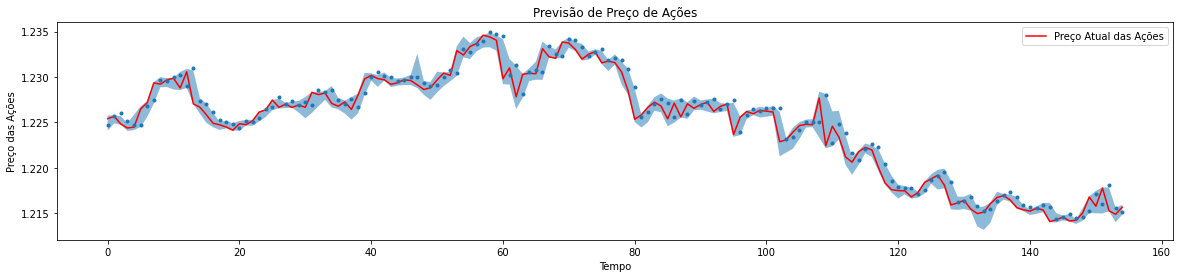

In [28]:
estatisticalTested.graphicMaxMin(155)